<h1 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;">
<strong><centre>Pre-processing</centre></strong></h1>


#### Import Libraries and Load Data

In [2]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt


#### Load Dataset:

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf

train_dir = 'data/train'
test_dir = 'data/test'
val_dir = 'data/valid'

#classes to be used
classes = ['football', 'formula 1 racing', 'nascar racing', 'baseball', 'hockey', 'basketball',
           'olympic wrestling', 'rugby', 'canoe slalom', 'roller derby', 'high jump',
           'rollerblade racing', 'field hockey', 'figure skating women', 'golf', 'polo',
           'rings', 'swimming', 'uneven bars', 'figure skating pairs']

Num GPUs Available:  0


### Data Augmentation

In [4]:
import math

def load_data(data_dir, batch_size, img_size):
    datagen = ImageDataGenerator(
        rotation_range=30, #Randomly rotate images in the range of 30 degrees.
        width_shift_range=0.2, #Randomly shift images horizontally by 20% of the width.
        height_shift_range=0.2, #Randomly shift images vertically by 20% of the height.
        shear_range=0.2, #Apply shear transformation.
        zoom_range=0.2,#Randomly zoom in and out by 20%.
        horizontal_flip=True,#Randomly flip images horizontally.
        fill_mode='nearest'#Pixels outside the boundaries of the input are filled according to the nearest mode.
    )
    data_flow = datagen.flow_from_directory(
        data_dir,
        class_mode="categorical",
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        classes=classes
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: data_flow,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, *img_size, 3], [None, len(classes)])
    )
    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE), math.ceil(data_flow.samples / batch_size)
#dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE): Prefetches the data to improve performance by overlapping the data preprocessing and model execution.
    #buffer_size=tf.data.experimental.AUTOTUNE: TensorFlow automatically tunes the buffer size.
#math.ceil(data_flow.samples / batch_size): Calculates the number of steps per epoch by dividing the total number of samples by the batch size and taking the ceiling.

img_size = (150, 150)

#### Data Distribution:

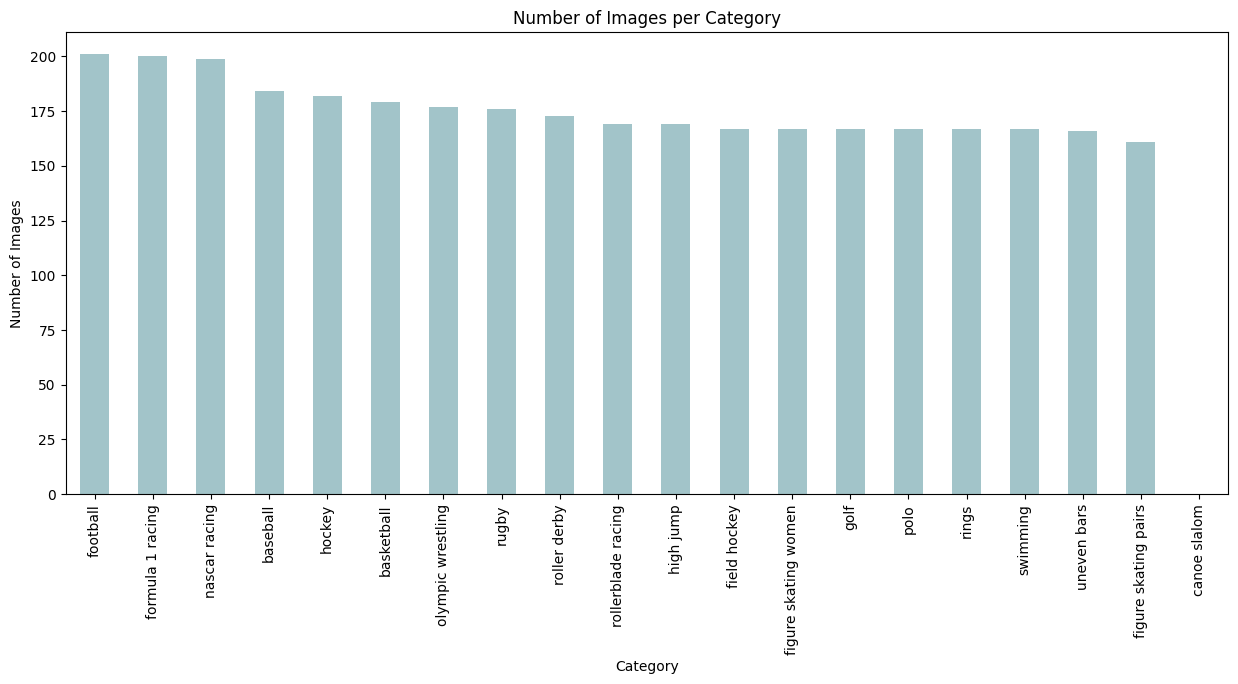

In [5]:

# Define the data directories and categories (classes)
data_dirs = ['data/train', 'data/valid', 'data/test']
categories = ['football', 'formula 1 racing', 'nascar racing', 'baseball', 'hockey', 'basketball',
              'olympic wrestling', 'rugby', 'canoe slalom', 'roller derby', 'high jump',
              'rollerblade racing', 'field hockey', 'figure skating women', 'golf', 'polo',
              'rings', 'swimming', 'uneven bars', 'figure skating pairs']

# Initialize a dictionary to count images per category
category_counts = {category: 0 for category in categories}

# Count the number of images in each category across all directories
for data_dir in data_dirs:
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if os.path.exists(category_path):
            category_counts[category] += len(os.listdir(category_path))

# Convert the dictionary to a pandas Series and sort
category_counts = pd.Series(category_counts).sort_values(ascending=False)

# Plot the number of images per category
category_counts.plot(kind='bar', figsize=(15, 6), color='#a2c4c9')
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()


#### Split the dataset into training and validation datasets

---

In [6]:
train_dataset, steps_per_epoch = load_data(train_dir, batch_size=64, img_size=img_size)
val_dataset, validation_steps = load_data(val_dir, batch_size=64, img_size=img_size)
test_dataset, test_steps = load_data(test_dir, batch_size=64, img_size=img_size)

Found 3147 images belonging to 20 classes.
Found 95 images belonging to 20 classes.
Found 95 images belonging to 20 classes.


<h1 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;">
<strong><centre>Model Training</centre></strong></h1>

### Base Model

---

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization,ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# Número de classes
num_classes = len(classes)

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32,kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(units=num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │     3,504,660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,505,556 (13.37 MB)

 Trainable params: 3,505,556 (13.37 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 425ms/step - accuracy: 0.0795 - loss: 447.6369 - val_accuracy: 0.2105 - val_loss: 99.2961
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 417ms/step - accuracy: 0.1858 - loss: 85.4908 - val_accuracy: 0.2947 - val_loss: 47.3854
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - accuracy: 0.2234 - loss: 62.7267 - val_accuracy: 0.2947 - val_loss: 38.9770
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - accuracy: 0.2740 - loss: 58.2490 - val_accuracy: 0.3684 - val_loss: 35.8717
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - accuracy: 0.2753 - loss: 48.3129 - val_accuracy: 0.3684 - val_loss: 27.6773
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 420ms/step - accuracy: 0.3115 - loss: 38.0505 - val_accuracy: 0.3158 - val_loss: 28.9931
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - accuracy: 0.2981 - loss: 34.1535 - val_accuracy: 0.3684 - val_loss: 22.2917
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 424ms/step - accuracy: 0.3253 - loss: 27

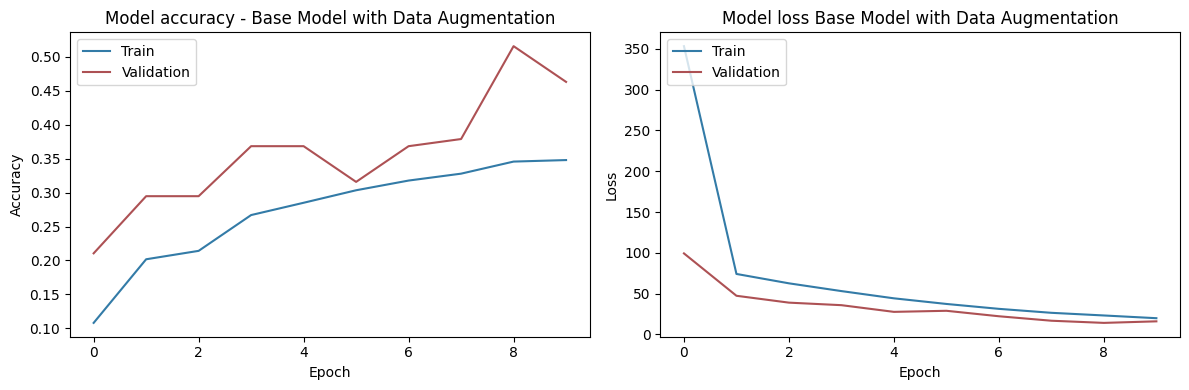

In [9]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'], color='#337ba7')
    ax1.plot(history.history['val_accuracy'], color='#ad5154')
    ax1.set_title('Model accuracy - Base Model with Data Augmentation')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'], color='#337ba7')
    ax2.plot(history.history['val_loss'], color='#ad5154')
    ax2.set_title('Model loss Base Model with Data Augmentation')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


In [11]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=test_steps)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")
model.save('final_model_base_model.keras')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.3602 - loss: 13.3226
Test accuracy: 36.84%
Test loss: 13.3043
